# **Coleridge Initiative - Show US the Data**

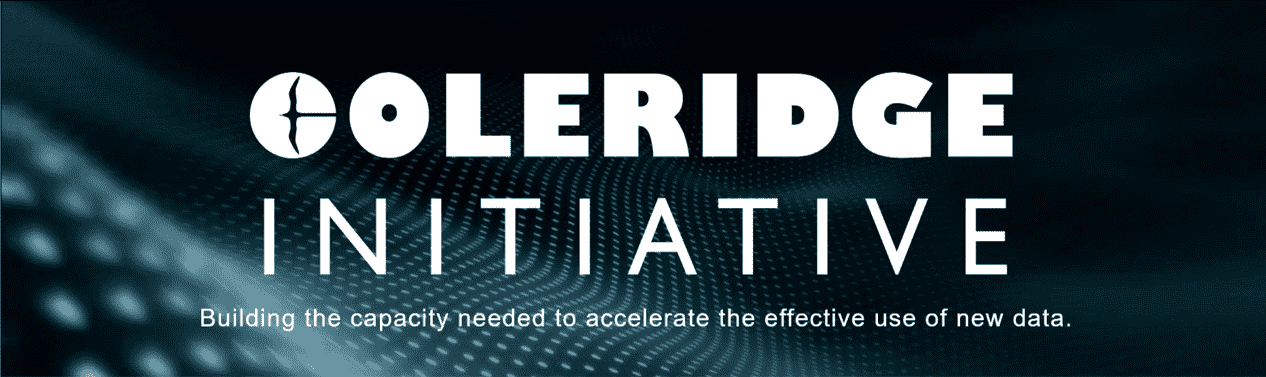

**Aim of the competition is to predict excerpts from the longer texts for each publication that appear to denote a data-set name or title**

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background-color:#142B33; border:0' role="tab" aria-controls="home"><center>Overview of the Notebook</center></h2>

* [Data Details](#1)
* [Loading publication data from json files for given data-label and publication-id](#2)
* [EDA on the loaded publication data](#3)
* [Static data-label matching and submission](#4)


<a id="1"></a>
<h2 style='background-color:#142B33; border:0; color:white'><center>Data Details <center><h2>

In [ ]:
import pandas as pd
import os
os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data')

Data provided to us in this competition comprises of following 4 items:

1. train.csv - This file comprises of publication-id and the associated data title and labels along with the cleansed label.
2. train folder - This folder provides json file for each of the id's present in the above csv file, with each of the json file describing section-details of the publication and the associated text with it.
3. sample_submission.csv - This file comprises of id, for which we must predict the data-set title.
4. test folder - This folder provides json file for each of the id's present in test.csv file and the json file describes the section details of the publication and the associated text.

In [ ]:
import pandas as pd
df_train=pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
df_train.head()

In [ ]:
print('Total rows in the train data set are :'+str(len(df_train)))

In [ ]:
for col in df_train.columns:
    print(f"{col}: {len(df_train[col].unique())}")


In [ ]:
df_train['dataset_title'].value_counts()

**Similarly Let us Load the Test Data**

In [ ]:
df_test=pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
df_test

<a id="2"></a>
<h2 style='background-color:#142B33; border:0; color:white'><center>Loading publication data from json files for given data-label and publication-id <center><h2>

1. **Here we consider publication-id's from train-data frame and use it to read the json data from train folder.**

2. **Each json file contains multiple sections, an example of one such id is shown below:**
 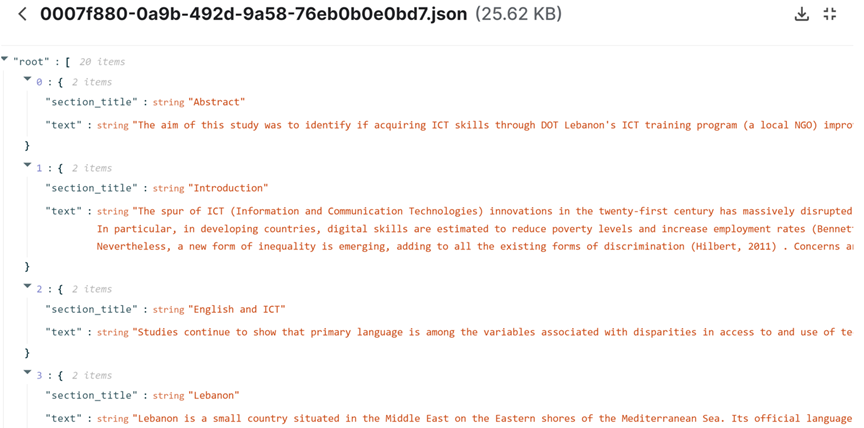
 
3. **We see that each json file/ each publication-id has multiple sections with corresponding text-data, we are going to use this further.**
 
4. **Above structure is leveraged to retrieve the section-name and its associated text by verifying if the text present in each of those section contains the data-label or not.**
 
5. **Once we execute the above step, we filter for section-name whose section-text contains the data-label.**

In [ ]:
df_input = pd.DataFrame(columns=['id','section_title','text','data_label'])
ids=df_train['Id'].values
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
#len(ids)
for id in ids:
    df=pd.read_json ('../input/coleridgeinitiative-show-us-the-data/train/{}.json'.format(id))
    for data_label in df_train[df_train['Id']==id]['dataset_label'].values:
        new_df=df[df['text'].str.contains(data_label)].copy(deep=True)
        new_df.loc[:,['data_label']] = data_label
        new_df.loc[:,['id']] = id
        new_df.reset_index(inplace=True,drop=True)
        df_input=pd.concat([df_input, new_df], ignore_index=True)
        df_input.reset_index(inplace=True,drop=True)

    

In [ ]:
df_input.head()

<a id="3"></a>
<h2 style='background-color:#142B33; border:0; color:white'><center>EDA on the loaded publication data <center><h2>

### **Let’s see if there are any null values present in our dataset:**

In [ ]:
df_input.isnull().sum()


**There are no null values in the dataset.**

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

### **Term Frequency Analysis of data-label**

In [ ]:
words =list( df_input['data_label'].values)
words=[word.split() for word in words]

In [ ]:
allwords = []
for wordlist in words:
    allwords += wordlist
#print(allwords)

In [ ]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Data Label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Freq of 25 Most Common Words in Data-Label', fontsize=60)
plt.show()

### **Term Frequency Analysis of Section-Title**

In [ ]:
words =list( df_input['section_title'].values)
stopwords=['ourselves', 'hers','the', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Section Title', fontsize=50)
plt.tight_layout(pad=0)
plt.show()
#print(allwords)
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Freq of 25 Most Common Words in Section-Title', fontsize=60)
plt.show()

<a id="4"></a>
<h2 style='background-color:#142B33; border:0; color:white'><center>Static data-label matching and submission <center><h2>

In [ ]:
df_test_input = pd.DataFrame(columns=['id','section_title','text'])
ids=df_test['Id'].values
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
#len(ids)
for id in ids:
    df=pd.read_json ('../input/coleridgeinitiative-show-us-the-data/test/{}.json'.format(id))
    df.loc[:,['id']] = id
    df.reset_index(inplace=True,drop=True)
    df_test_input=pd.concat([df_test_input, df], ignore_index=True)
    df_test_input.reset_index(inplace=True,drop=True) 

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()
submission_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv', index_col=0)
submission_df

In [ ]:
df_test_input['length'] = df_test_input.text.str.len()
df_test_input =df_test_input[df_test_input.length > 0]
submission_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv', index_col=0)
datasets_titles = [str(x).lower() for x in df_input['data_label'].unique()]
import re
labels = []
for index in submission_df.index:
    publication_text = df_test_input[df_test_input['id'] == index].text.str.cat(sep='\n').lower()
    label = []
    for dataset_title in datasets_titles:
        if dataset_title in publication_text:
            label.append(clean_text(dataset_title))
    labels.append('|'.join(label))

submission_df['PredictionString'] = labels

submission_df.to_csv('submission.csv')

submission_df

**Some of the work in this notebook are created using the following notebook, if you like mine, then vist and like the following one as well**
https://www.kaggle.com/josephassaker/coleridge-initiative-eda-na-ve-submission